# parPE Raia example model

In [16]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

In [37]:
# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/amici/examples/raia/raia-prefix/src/raia/raia'
example_binary_dir = f'{parpe_build_root}/amici/raia/raia/'
example_data_dir = f'{parpe_build_root}/amici/examples/raia/raia-prefix/src/raia'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.2.0-35-gec7ba-dirty
[  0%] Built target get_version
[  7%] Built target parpecommon
[  9%] Built target parpeloadbalancer
[ 17%] Built target parpeoptimization
[ 25%] Built target parpeamici
[ 26%] Built target parpe
[ 30%] Built target unittests_common
[ 34%] Built target unittests_optimization_ipopt
[ 41%] Built target unittests_optimization
[ 44%] Built target unittests_optimization_ceres
[ 47%] Built target unittests_loadbalancer
[ 48%] Built target example_loadbalancer
[ 56%] Built target steadystate_scaled
[ 59%] Built target example_steadystate
[ 63%] Built target example_steadystate_parallel
[ 65%] Built target example_steadystate_multi
[ 68%] Built target example_steadystate_multi_simulator
[ 72%] Built target test_steadystate
[ 79%] Built target lucarelli_12
[ 81%] Built target estimateLucarelli
[ 83%] Built target simulateLucarelli
[ 90%] Built target raia
[ 92%] Built target estimateRaia
[ 93%

## Test simulation

In [38]:
def plotStateTrajectories(rdata):
    for ix in range(0,rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


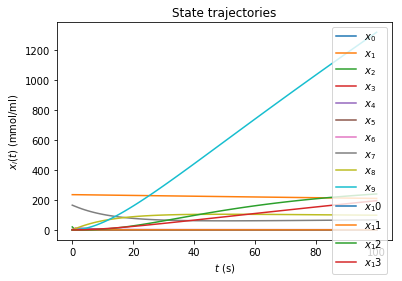

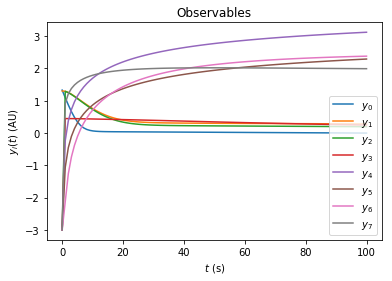

In [39]:
# load model
sys.path.insert(0, model_source_dir)
import raia as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 100, 100))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Prepare parameter estimation with minibatch optimizer

- Load simulated data
- Edit optimization options

In [40]:
input_file = f'{example_data_dir}/example_data.h5'
!../../../misc/optimizationOptions.py {input_file} -s numStarts 1
!../../../misc/optimizationOptions.py {input_file} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {input_file} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {input_file} -s minibatch/maxEpochs 5
!../../../misc/optimizationOptions.py {input_file} -s minibatch/batchSize 1
!../../../misc/optimizationOptions.py {input_file} -s minibatch/parameterUpdater Vanilla
!../../../misc/optimizationOptions.py {input_file} -s minibatch/learningRateInterpMode linear
!../../../misc/optimizationOptions.py {input_file} -s minibatch/rescueInterceptor 0
!../../../misc/optimizationOptions.py {input_file} -s retryOptimization 0
!../../../misc/optimizationOptions.py {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Rebuild executables

In [41]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme

/home/paul/Documents/parpe/parPE/amici/examples/raia
[  7%] Built target parpecommon
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.2.0-35-gec7ba-dirty
[  7%] Built target get_version
[ 11%] Built target unittests_common
[ 13%] Built target parpeloadbalancer
[ 21%] Built target parpeoptimization
[ 25%] Built target unittests_loadbalancer
[ 25%] Built target example_loadbalancer
[ 33%] Built target parpeamici
[ 36%] Built target unittests_optimization_ceres
[ 40%] Built target unittests_optimization_ipopt
[ 47%] Built target unittests_optimization
[ 54%] Built target lucarelli_12
[ 61%] Built target raia
[ 62%] Built target parpe
[ 70%] Built target steadystate_scaled
[ 77%] Built target unittests_amici
[ 79%] Built target estimateLucarelli
[ 80%] Built target simulateRaia
[ 82%] Built target simulateLucarelli
[ 84%] Built target estimateRaia
[ 87%] Built target example_steadystate_multi_simulator
[ 89%] Built target example_steadystate_multi
[ 92%] Bu

## Minibatch optimization

In [42]:
!mpiexec -np 4 ../../../build/amici/examples/raia/estimateRaia -o deleteme-minibatch/ {input_file}

[2019-02-01 20:47:14] [DBG] [1/paul-ubuntu] Rank 1/4 running on paul-ubuntu.
[2019-02-01 20:47:14] [DBG] [2/paul-ubuntu] Rank 2/4 running on paul-ubuntu.
[2019-02-01 20:47:14] [DBG] [3/paul-ubuntu] Rank 3/4 running on paul-ubuntu.
[2019-02-01 20:47:14] [DBG] [3/paul-ubuntu] Seeding RNG with 1549050434
[2019-02-01 20:47:14] [DBG] [1/paul-ubuntu] Seeding RNG with 1549050434
[2019-02-01 20:47:14] [DBG] [2/paul-ubuntu] Seeding RNG with 1549050434
[2019-02-01 20:47:14] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
[2019-02-01 20:47:14] [DBG] [0/paul-ubuntu] Rank 0/4 running on paul-ubuntu.
[2019-02-01 20:47:14] [DBG] [0/paul-ubuntu] Seeding RNG with 1549050434
[2019-02-01 20:47:14] [INF] [0/paul-ubuntu] Reading options and data from '/home/paul/Documents/parpe/parPE/build/amici/examples/raia/raia-prefix/src/raia/example_data.h5'.
[2019-02-01 20:47:14] [DBG] [0/paul-ubuntu] Starting runParallelMultiStartOptimization with 1 starts
[2019-02-01 20:47:14] [INF] [0/paul-ubuntu] Reading rand

[2019-02-01 20:47:19] [DBG] [1/paul-ubuntu] [o0e2b0c8] Result for 21: -2476.33 (0) (0.1640s+)
[2019-02-01 20:47:19] [DBG] [0/paul-ubuntu] [o0e2b0] : Cost: 2476.33 |g|2: 1524.19 Batch: [ 8 ] LearningRate: 0.0505

[2019-02-01 20:47:19] [DBG] [1/paul-ubuntu] Message received after waiting 0.003073s.
[2019-02-01 20:47:20] [DBG] [1/paul-ubuntu] [o0e2b1c5] Result for 22: -1873.72 (0) (0.3439s+)
[2019-02-01 20:47:20] [DBG] [0/paul-ubuntu] [o0e2b1] : Cost: 1873.72 |g|2: 1687.96 Batch: [ 5 ] LearningRate: 0.0505

[2019-02-01 20:47:20] [DBG] [1/paul-ubuntu] Message received after waiting 0.002162s.
[2019-02-01 20:47:20] [DBG] [1/paul-ubuntu] [o0e2b2c0] Result for 23: -1431.12 (0) (0.2471s+)
[2019-02-01 20:47:20] [DBG] [0/paul-ubuntu] [o0e2b2] : Cost: 1431.12 |g|2: 1779.18 Batch: [ 0 ] LearningRate: 0.0505

[2019-02-01 20:47:20] [DBG] [1/paul-ubuntu] Message received after waiting 0.010546s.
[2019-02-01 20:47:20] [DBG] [1/paul-ubuntu] [o0e2b3c2] Result for 24: -1465.74 (0) (0.2222s+)
[2019-02-01 

[2019-02-01 20:47:27] [DBG] [0/paul-ubuntu] [o0e4b4] : Cost: 1839.64 |g|2: 454.807 Batch: [ 8 ] LearningRate: 0.001

[2019-02-01 20:47:27] [DBG] [1/paul-ubuntu] Message received after waiting 0.002501s.
[2019-02-01 20:47:27] [DBG] [1/paul-ubuntu] [o0e4b5c4] Result for 46: -866.217 (0) (0.2687s+)
[2019-02-01 20:47:27] [DBG] [0/paul-ubuntu] [o0e4b5] : Cost: 866.217 |g|2: 746.587 Batch: [ 4 ] LearningRate: 0.001

[2019-02-01 20:47:27] [DBG] [1/paul-ubuntu] Message received after waiting 0.003167s.
[2019-02-01 20:47:28] [DBG] [1/paul-ubuntu] [o0e4b6c7] Result for 47: -1661.83 (0) (0.2372s+)
[2019-02-01 20:47:28] [DBG] [0/paul-ubuntu] [o0e4b6] : Cost: 1661.83 |g|2: 467.214 Batch: [ 7 ] LearningRate: 0.001

[2019-02-01 20:47:28] [DBG] [1/paul-ubuntu] Message received after waiting 0.018764s.
[2019-02-01 20:47:28] [DBG] [1/paul-ubuntu] [o0e4b7c6] Result for 48: -1394.81 (0) (0.3131s+)
[2019-02-01 20:47:28] [DBG] [0/paul-ubuntu] [o0e4b7] : Cost: 1394.81 |g|2: 516.189 Batch: [ 6 ] LearningRate:

## IpOpt optimization

In [43]:
!../../../misc/optimizationOptions.py {input_file} -s numStarts 1
!../../../misc/optimizationOptions.py {input_file} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

In [44]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/raia/estimateRaia -o deleteme/ {input_file}


[2019-02-01 20:48:00] [DBG] [1/paul-ubuntu] Rank 1/4 running on paul-ubuntu.
[2019-02-01 20:48:00] [DBG] [1/paul-ubuntu] Seeding RNG with 1549050480
[2019-02-01 20:48:00] [DBG] [3/paul-ubuntu] Rank 3/4 running on paul-ubuntu.
[2019-02-01 20:48:00] [DBG] [3/paul-ubuntu] Seeding RNG with 1549050480
[2019-02-01 20:48:00] [DBG] [2/paul-ubuntu] Rank 2/4 running on paul-ubuntu.
[2019-02-01 20:48:00] [DBG] [2/paul-ubuntu] Seeding RNG with 1549050480
[2019-02-01 20:48:00] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
[2019-02-01 20:48:00] [DBG] [0/paul-ubuntu] Rank 0/4 running on paul-ubuntu.
[2019-02-01 20:48:00] [DBG] [0/paul-ubuntu] Seeding RNG with 1549050480
[2019-02-01 20:48:00] [INF] [0/paul-ubuntu] Reading options and data from '/home/paul/Documents/parpe/parPE/build/amici/examples/raia/raia-prefix/src/raia/example_data.h5'.
[2019-02-01 20:48:00] [DBG] [0/paul-ubuntu] Starting runParallelMultiStartOptimization with 1 starts
[2019-02-01 20:48:00] [INF] [0/paul-ubuntu] Reading rand

[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] [o0e2b0c2] Result for 21: -1725.95 (0) (0.1255s+)
[2019-02-01 20:48:04] [DBG] [0/paul-ubuntu] [o0e2b0] : Cost: 1725.95 |g|2: 1957.48 Batch: [ 2 ] LearningRate: 0.0505

[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] Message received after waiting 0.002489s.
[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] [o0e2b1c9] Result for 22: -2401.34 (0) (0.1228s+)
[2019-02-01 20:48:04] [DBG] [0/paul-ubuntu] [o0e2b1] : Cost: 2401.34 |g|2: 1289.98 Batch: [ 9 ] LearningRate: 0.0505

[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] Message received after waiting 0.001896s.
[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] [o0e2b2c8] Result for 23: -2335.37 (0) (0.1079s+)
[2019-02-01 20:48:04] [DBG] [0/paul-ubuntu] [o0e2b2] : Cost: 2335.37 |g|2: 1295.11 Batch: [ 8 ] LearningRate: 0.0505

[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] Message received after waiting 0.001159s.
[2019-02-01 20:48:04] [DBG] [1/paul-ubuntu] [o0e2b3c7] Result for 24: -2122.32 (0) (0.1159s+)
[2019-02-01 

[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] [o0e4b5c3] Result for 46: -914.667 (0) (0.1029s+)
[2019-02-01 20:48:07] [DBG] [0/paul-ubuntu] [o0e4b5] : Cost: 914.667 |g|2: 816.806 Batch: [ 3 ] LearningRate: 0.001

[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.000994s.
[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] [o0e4b6c0] Result for 47: -588.731 (0) (0.1170s+)
[2019-02-01 20:48:07] [DBG] [0/paul-ubuntu] [o0e4b6] : Cost: 588.731 |g|2: 919.268 Batch: [ 0 ] LearningRate: 0.001

[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.004558s.
[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] [o0e4b7c6] Result for 48: -1393.95 (0) (0.1134s+)
[2019-02-01 20:48:07] [DBG] [0/paul-ubuntu] [o0e4b7] : Cost: 1393.95 |g|2: 513.765 Batch: [ 6 ] LearningRate: 0.001

[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.000809s.
[2019-02-01 20:48:07] [DBG] [1/paul-ubuntu] [o0e4b8c1] Result for 49: -699.914 (0) (0.0961s+)
[2019-02-01 20:

array([[4478.7144068 , 1882.3765073 , 1011.06728603, 1920.01585646,
         588.36839887]])

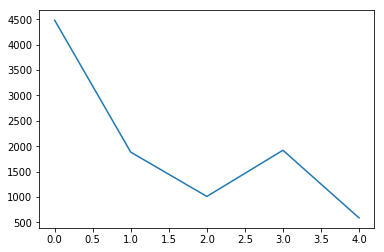

In [15]:
filename = 'deleteme/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory